In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import torch
import matplotlib.pyplot as plt
from flipper_training.configs import *
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *
from copy import deepcopy
from collections import deque

In [3]:
from flipper_training.vis.pltvis import *

In [4]:
torch.random.manual_seed(420)

In [5]:
num_robots = 1

In [6]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing='xy')

In [7]:
# gaussian hm
z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
     0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
     2.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
     ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([1, 256, 256])

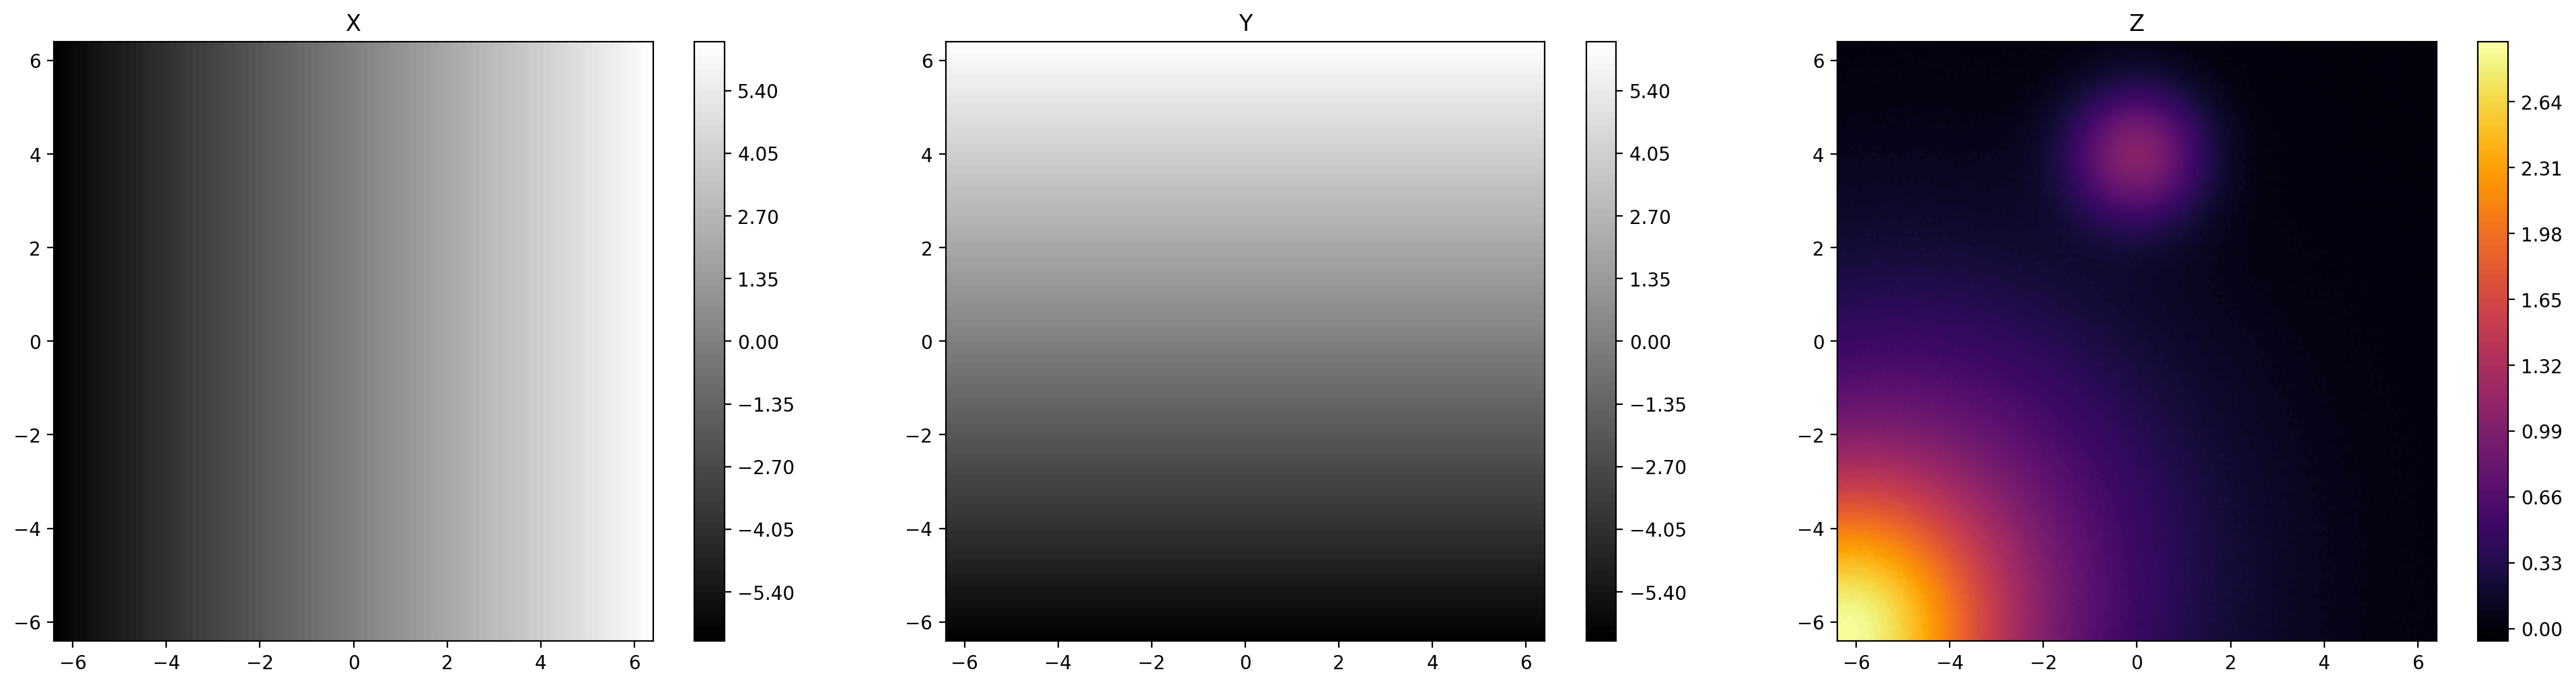

In [43]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [9]:
device = "cpu"

In [10]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", voxel_size=0.08, points_per_driving_part=150)
world_config = WorldConfig(x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord, k_stiffness=30000)
physics_config = PhysicsEngineConfig(num_robots=num_robots)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.cache/marv_0.080_150.pt


In [11]:
# Controls
traj_length = 15.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 1.0  # m/s forward
omega = -0.5  # rad/s yaw
controls = robot_model.get_controls(torch.tensor([speed, omega]))
flipper_controls = torch.zeros_like(controls)

In [12]:
for cfg in [robot_model, world_config, physics_config]:
    cfg.move_all_tensors_to_device(device)

In [13]:
engine = DPhysicsEngine(physics_config, robot_model, device)

In [14]:
x0 = torch.tensor([-6, -6, 5.]).to(device).repeat(num_robots, 1)
xd0 = torch.zeros_like(x0)
R0 = torch.eye(3).to(device).repeat(num_robots, 1, 1)
omega0 = torch.zeros_like(x0)
thetas0 = torch.zeros(num_robots, 4).to(device)
local_robot_points0 = robot_model.robot_points.to(device).repeat(num_robots, 1, 1)
controls_all = torch.cat((controls, flipper_controls)).unsqueeze(0).repeat(n_iters, num_robots, 1).to(device)

In [15]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi
periods = 2
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, len(controls)] = rot_vels
controls_all[:, :, len(controls) + 1] = rot_vels
controls_all[:, :, len(controls) + 2] = -rot_vels
controls_all[:, :, len(controls) + 3] = -rot_vels

In [16]:
init_state = PhysicsState(x0, xd0, R0, local_robot_points0, omega0, thetas0)

In [17]:
bench_state = deepcopy(init_state)

In [18]:
compile = True

In [19]:
if compile:
    # run all torch compilation
    engine = torch.compile(engine)
    _ = engine(bench_state, controls_all[0], world_config)

In [20]:
%%timeit -o
_ = engine(bench_state, controls_all[0],world_config)

775 µs ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<TimeitResult : 775 µs ± 44.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)>

In [21]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [22]:
%%time 
state = deepcopy(init_state)
i = 0
for ctrl in controls_all:
    state, der, aux = engine(state, ctrl, world_config)
    states.append(deepcopy(state))
    dstates.append(der)
    auxs.append(aux)
    i += 1

CPU times: user 8.25 s, sys: 2.87 s, total: 11.1 s
Wall time: 1.65 s


In [23]:
from flipper_training.engine.engine_state import vectorize_iter_of_tensor_tuples

In [24]:
states_vec = vectorize_iter_of_tensor_tuples(states)
dstates_vec = vectorize_iter_of_tensor_tuples(dstates)
aux_vec = vectorize_iter_of_tensor_tuples(auxs)

In [39]:
x_grid[0]

tensor([[-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000],
        [-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000],
        [-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000],
        ...,
        [-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000],
        [-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000],
        [-6.4000, -6.3498, -6.2996,  ...,  6.2996,  6.3498,  6.4000]])

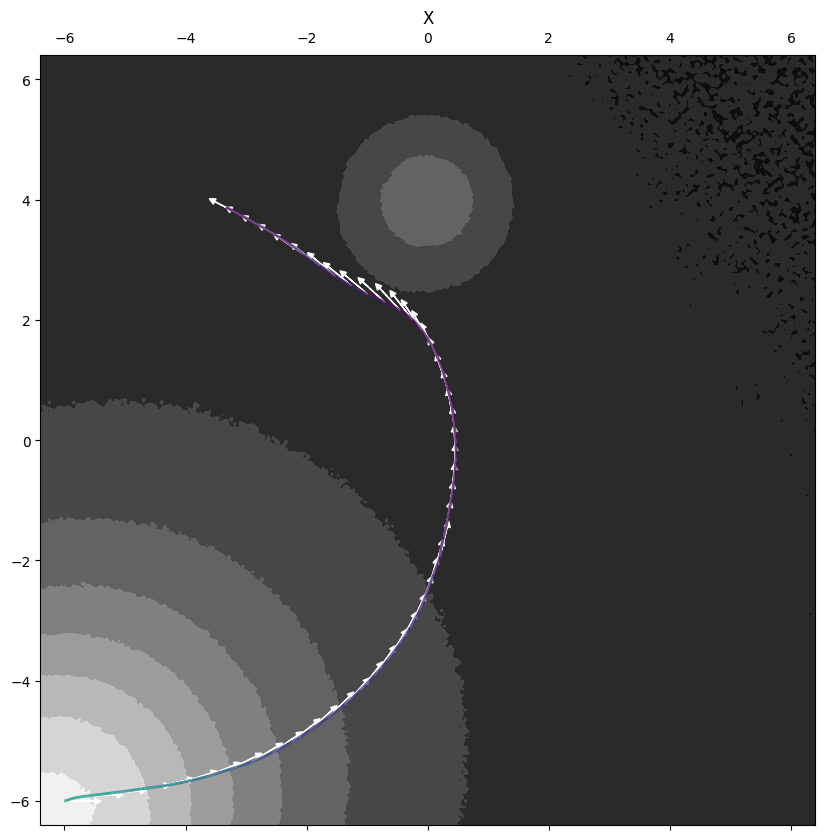

In [42]:
from matplotlib.collections import LineCollection

ROBOT_IDX = 0
ITERSTEP = 30
x_vis = x_grid[ROBOT_IDX].cpu().numpy()
y_vis = y_grid[ROBOT_IDX].cpu().numpy()
z_vis = z_grid[ROBOT_IDX].cpu().numpy()

# Heightmap plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax.contourf(x_vis, y_vis, z_vis, cmap='gray')
ax.set_title("X")
ax.xaxis.tick_bottom()  # Move X-axis ticks to the top
ax.yaxis.tick_left()  # Move Y-axis ticks to the left
ax.tick_params(axis='x', labeltop=True, labelbottom=False)  # Show labels on top and hide them on bottom
xs, ys, zs = states_vec.x[:, ROBOT_IDX, :].T

for i in range(0, len(states_vec.x), ITERSTEP):
    pos = states_vec.x[i, ROBOT_IDX]
    yaw = yaw_from_R(states_vec.R[i, ROBOT_IDX].cpu())
    # plt.text(*pos[:2], str(i), fontsize=12, color='white')
    plt.arrow(pos[0], pos[1], 0.5 * torch.cos(yaw), 0.5 * torch.sin(yaw), head_width=0.1, head_length=0.1, fc='w', ec='w')

np_points = np.array([xs, ys]).T.reshape(-1, 1, 2)
segments = np.concatenate([np_points[:-1], np_points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(min(zs), max(zs)))
lc.set_array(np.array(zs))
lc.set_linewidth(2)
line = ax.add_collection(lc)

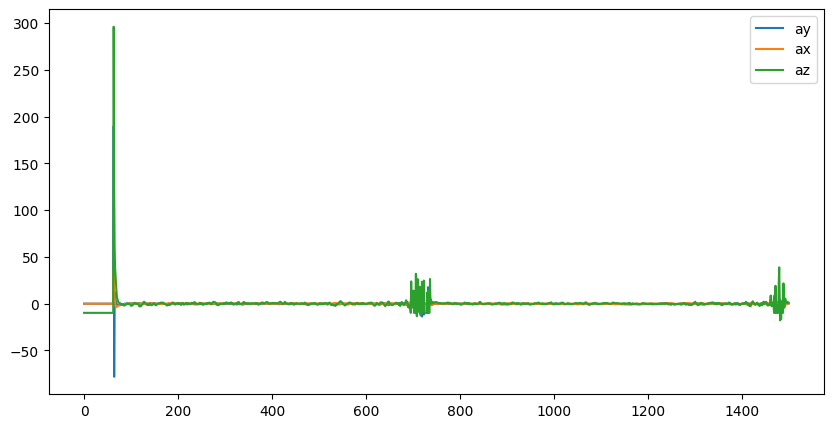

In [27]:
# Plot components of acceleration
ay, ax, az = dstates_vec.xdd[:, ROBOT_IDX].T
plt.figure(figsize=(10, 5))
plt.plot(ay, label='ay')
plt.plot(ax, label='ax')
plt.plot(az, label='az')
plt.legend()

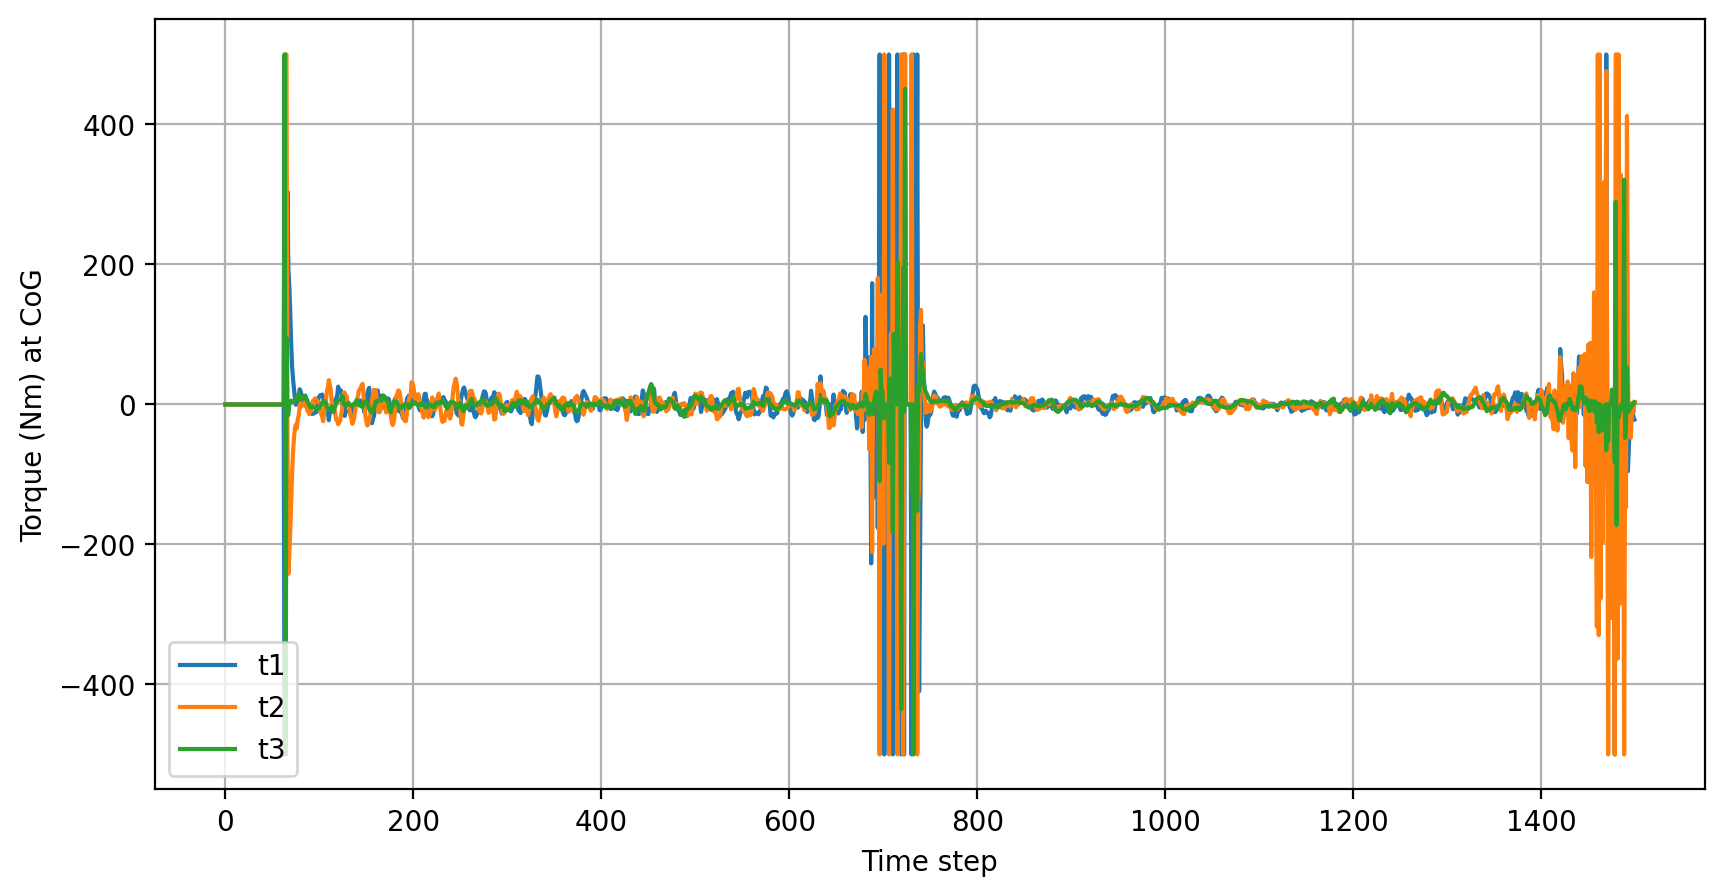

In [28]:
# Plot components of torque
t1, t2, t3 = aux_vec.torque[:, ROBOT_IDX].T
plt.figure(figsize=(10, 5), dpi=200)
plt.plot(t1, label='t1')
plt.plot(t2, label='t2')
plt.plot(t3, label='t3')
plt.grid()
plt.xlabel('Time step')
plt.ylabel('Torque (Nm) at CoG')
plt.legend()

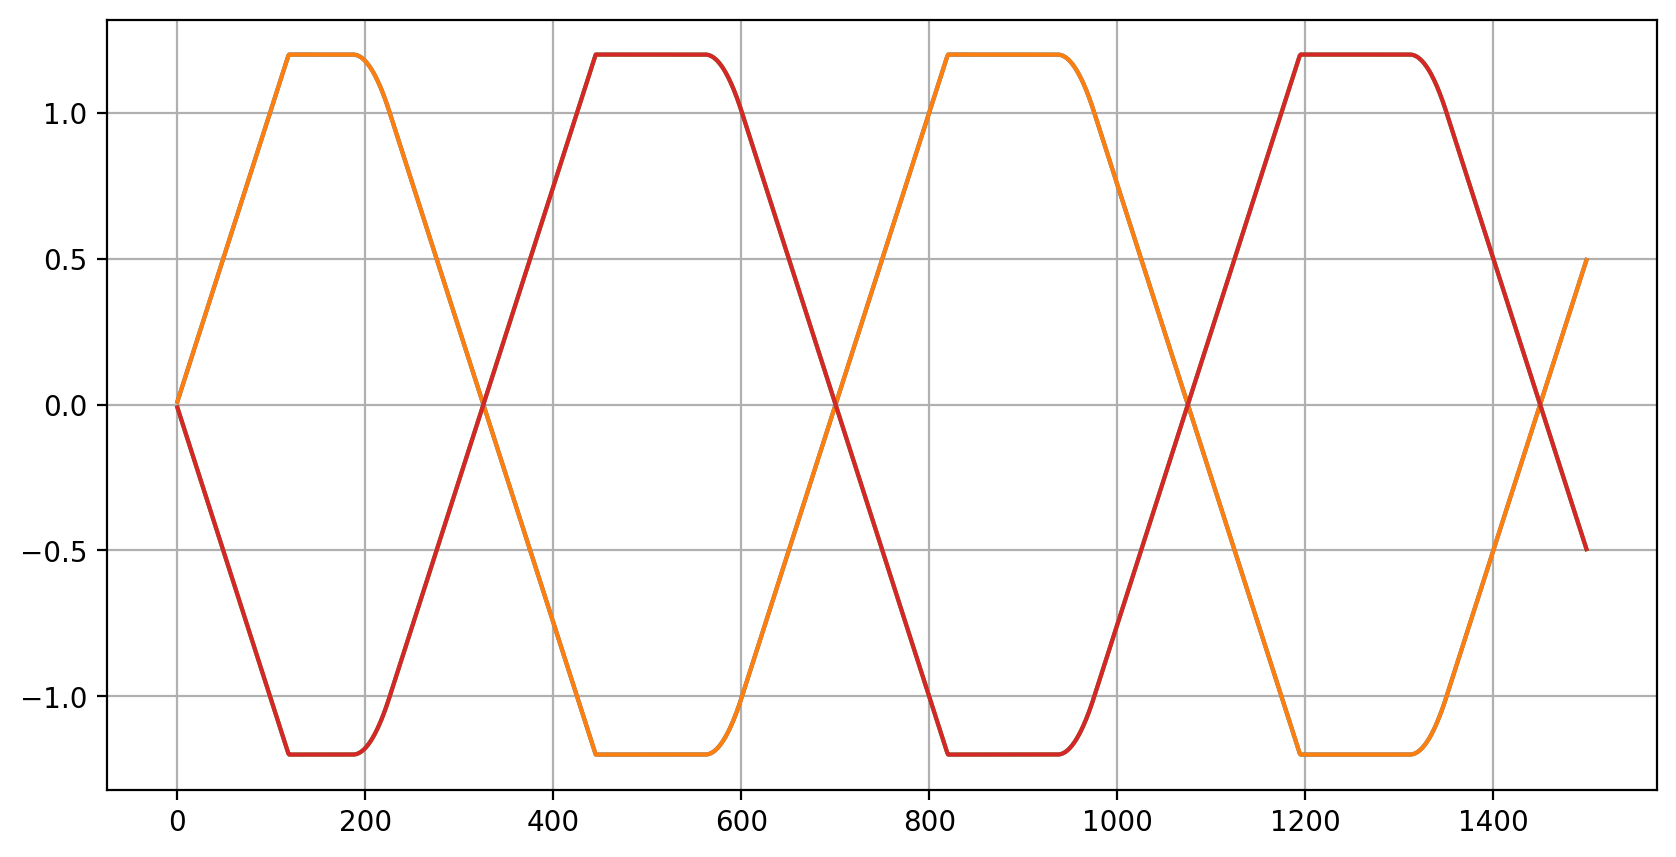

In [29]:
# Joint angles
plt.figure(figsize=(10, 5), dpi=200)
theta1, theta2, theta3, theta4 = states_vec.thetas[:, ROBOT_IDX].T
plt.plot(theta1, label='theta1')
plt.plot(theta2, label='theta2')
plt.plot(theta3, label='theta3')
plt.plot(theta4, label='theta4')
plt.grid()

In [30]:
robot_model.visualize_robot(robot_points=states_vec.local_robot_points[700, ROBOT_IDX])

X: red, Y: green, Z: blue
Robot has 855 points


2024-12-28 21:20:32.771 Python[94098:1039386] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/yj/_6b0pqvs5xg33v_xy5q2v9_40000gn/T/org.python.python.savedState


Widget(value='<iframe src="http://localhost:59650/index.html?ui=P_0x33279cdd0_0&reconnect=auto" class="pyvista…

In [31]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])

# World

fig.add_trace(
    go.Surface(x=x_vis, y=y_vis, z=z_vis, colorscale='Viridis', showscale=False),
    row=1, col=1
)

# Trajectory

fig.add_trace(
    go.Scatter3d(x=xs, y=ys, z=zs, mode='lines', line=dict(color='red', width=5)),
)

# Robot pointcloud in last state

pts_global = aux_vec.global_robot_points[-1, ROBOT_IDX].cpu().numpy()
fig.add_trace(
    go.Scatter3d(x=pts_global[..., 0], y=pts_global[..., 1], z=pts_global[..., 2], mode='markers', marker=dict(size=5, color='blue')),
)

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Height (Z)',
        camera_eye=dict(x=1.25, y=1.25, z=1.25),
        aspectmode='manual',
        aspectratio=dict(
            x=1.,
            y=1.,
            z=zs.max().item() / (2 * max_coord)
        ),
    ),
    title_text='3D Heightmap',
)
fig.update_layout(
    width=1000,
    height=1000,
    margin=dict(l=20, r=20, t=20, b=20)
)

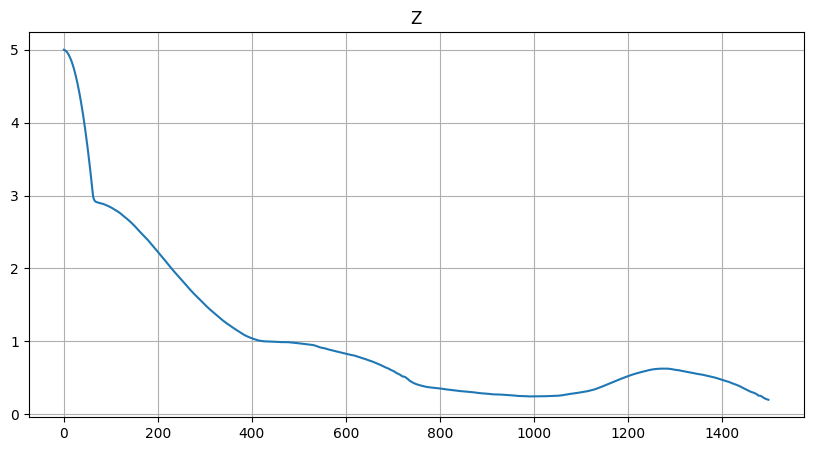

In [32]:
plt.figure(figsize=(10, 5), dpi=100)
plt.grid()
plt.title("Z")
plt.plot(zs)

In [33]:
from flipper_training.vis.visualizer import animate_trajectory

In [34]:
animate_trajectory(world_config, physics_config, states, auxs, 0)

2024-12-28 21:20:35.532 Python[94098:1039386] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-28 21:20:35.532 Python[94098:1039386] +[IMKInputSession subclass]: chose IMKInputSession_Modern
